In [138]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
df = pd.read_excel('./dataset.xls')

In [3]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
df.columns

Index(['Customer', 'Agent', 'SalesAgentEmailID', 'ContactEmailID', 'Stage',
       'Product', 'Close_Value', 'Created Date', 'Close Date'],
      dtype='object')

In [5]:
df.columns = ['customer', 'agent', 'sales_agent_emailID', 'contact_emailID', 'stage', \
       'product', 'close_value', 'created_date', 'close_date']

In [6]:
df.shape

(7800, 9)

In [7]:
df.isna().sum()

customer                  0
agent                     0
sales_agent_emailID       0
contact_emailID           0
stage                     0
product                   0
close_value            1208
created_date              0
close_date                0
dtype: int64

## I decided to train a model to predict *In Progress* values

### First of all i should fill NA values for *close_value* with mean of close_value for won and lost classes.

In [8]:
df[df.close_value.isna()].stage.value_counts()

Won            601
Lost           316
In Progress    291
Name: stage, dtype: int64

In [51]:
won_mean = df[df.stage=='Won'].close_value.mean()
lost_mean = df[df.stage=='Lost'].close_value.mean()
overall_mean = df.close_value.mean()


In [63]:
df.loc[(df.close_value.isna()) & (df.stage=='Won') ,'close_value'] = won_mean

In [73]:
df.loc[(df.close_value.isna()) & (df.stage=='Lost') ,'close_value'] = lost_mean

In [70]:
df.loc[(df.close_value.isna()) & (df.stage=='In Progress') ,'close_value'] = overall_mean

In [75]:
df.isna().sum()

customer               0
agent                  0
sales_agent_emailID    0
contact_emailID        0
stage                  0
product                0
close_value            0
created_date           0
close_date             0
dtype: int64

In [105]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [109]:
class Predictor :
    
    
    def __init__ (self, df:pd.DataFrame) :
        
        self.data = df.copy()
        self.le = LabelEncoder()
    
    def preprocess (self) :
        
        self.data.drop(['customer','sales_agent_emailID', 'contact_emailID' ], axis=1, inplace=True)
        
        self.data['diff_days'] = (self.data.close_date - self.data.created_date).dt.components.days
        
        self.data = self.data.join(pd.get_dummies(self.data['product'])).drop('product', axis=1)
        
        self.data.drop(['close_date', 'created_date'], axis=1, inplace=True)
    
        self.data.agent = le.fit_transform(self.data.agent)
        
        
    def generate_train_test (self) :
        data = self.data[self.data.stage!='In Progress']
        self.x_train,self.x_test , self.y_train,self.y_test = train_test_split(data.drop('stage',axis=1), \
                                                                               data.stage, random_state=101,\
                                                                               stratify = data.stage)
        
    def learn_model (self) :
        
        self.model = RandomForestClassifier()
        self.generate_train_test() 
        
        self.model.fit(self.x_train,self.y_train)
        
        return self.model
    
    
    def evaluate (self) :
        y_pred = self.model.predict(self.x_test) 
        
        print(classification_report(self.y_test, y_pred))
    
    def predict (self):
    
        y_pred = self.model.predict(self.data[self.data.stage=='In Progress'].drop('stage', axis=1))
        
        return y_pred
        
    
        
        
        
    
        

In [112]:
predictor = Predictor(df)

predictor.preprocess()


predictor.learn_model()



RandomForestClassifier()

In [111]:
predictor.evaluate()

              precision    recall  f1-score   support

        Lost       0.99      0.82      0.90       493
         Won       0.91      0.99      0.95       935

    accuracy                           0.94      1428
   macro avg       0.95      0.91      0.93      1428
weighted avg       0.94      0.94      0.93      1428



In [113]:
df.loc[df.stage=='In Progress', 'stage'] = predictor.predict()

## Which customers are more royal ?
### By the means of Number of boughts!

<AxesSubplot:>

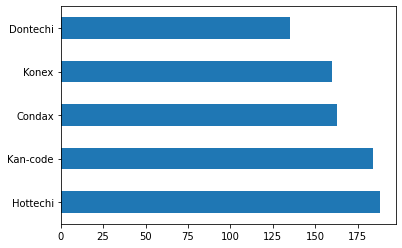

In [160]:
df.customer.value_counts().sort_values(ascending=False).head().plot.barh()

### By the means of amount of money they have been payed!

<AxesSubplot:ylabel='customer'>

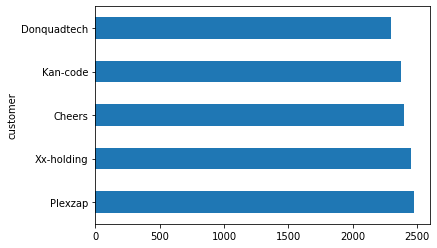

In [162]:
df.groupby('customer').mean()[['close_value']].sort_values(by='close_value', ascending=False).head().close_value.plot.barh()

## There are 30 agents in the dataset.

In [129]:
df.agent.nunique()

30

## Let's calculate rate of won for each sale.
### If a sale is in progress I will take it as None for not effecting rate of won-lost sales.

In [116]:
def numerical_stage(row) :
    if row['stage'] == 'Won':
        return 1 
    
    return -1 

df['rate'] = df.apply(numerical_stage, axis=1)

In [117]:
df = df.join(pd.get_dummies(df.stage))

## Let's see top 10 Agents by the means of rate

<AxesSubplot:ylabel='agent'>

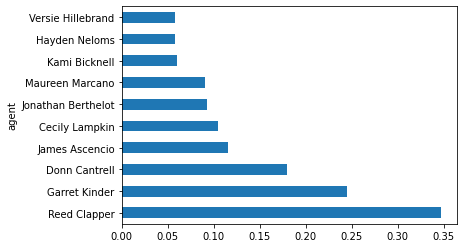

In [122]:
df.groupby('agent').mean().sort_values('rate',ascending=False).head(10).rate.plot.barh()

In [123]:
df.groupby('agent').mean().sort_values('rate',ascending=False).head(10)

,close_value,rate,Lost,Won
agent,,,,
Reed Clapper,2256.936356,0.346535,0.326733,0.673267
Garret Kinder,1994.480280,0.244898,0.377551,0.622449
Donn Cantrell,2214.729005,0.179487,0.410256,0.589744
James Ascencio,2283.977639,0.115880,0.442060,0.557940
Cecily Lampkin,1678.023135,0.104972,0.447514,0.552486
Jonathan Berthelot,1518.069025,0.092652,0.453674,0.546326
Maureen Marcano,1976.162340,0.090196,0.454902,0.545098
Kami Bicknell,1770.219236,0.059937,0.470032,0.529968
Hayden Neloms,1948.649924,0.057471,0.471264,0.528736


## What is best seller in dataset ?
### According to table below& *GTX Basic* is best seller!

In [132]:
df.groupby('product').mean().sort_values('rate', ascending=False)

,close_value,rate,Lost,Won
product,,,,
GTX Basic,1130.049599,0.071515,0.464242,0.535758
GTXPro,2975.841343,0.066463,0.466769,0.533231
GTX Plus Basic,1279.542082,0.048163,0.475918,0.524082
GTX Plus Pro,3099.242751,0.030162,0.484919,0.515081
MG Special,919.162357,0.016393,0.491803,0.508197
MG Advanced,2274.520477,-0.039936,0.519968,0.480032
GTK 500,10952.665502,-0.052632,0.526316,0.473684


## According to table above, worst item is *GTK 500* .
### So the question is who can sell this item better than any one ?

In [124]:
df.groupby('product').mean().sort_values('rate', ascending=False)

,close_value,rate,Lost,Won
product,,,,
GTX Basic,1130.049599,0.071515,0.464242,0.535758
GTXPro,2975.841343,0.066463,0.466769,0.533231
GTX Plus Basic,1279.542082,0.048163,0.475918,0.524082
GTX Plus Pro,3099.242751,0.030162,0.484919,0.515081
MG Special,919.162357,0.016393,0.491803,0.508197
MG Advanced,2274.520477,-0.039936,0.519968,0.480032
GTK 500,10952.665502,-0.052632,0.526316,0.473684


## *Rosalina Dieter* has sold *GTK 500* better than any one

In [128]:
df[df['product']=='GTK 500'].groupby('agent').sum().sort_values('rate', ascending=False)

,close_value,rate,Lost,Won
agent,,,,
Rosalina Dieter,137483.000000,5,1,6
Elease Gluck,184193.458057,0,9,9
Corliss Cosme,1014.000000,-1,1,0
Darcel Schlecht,493.000000,-1,1,0
Marty Freudenburg,1852.915504,-1,1,0
Markita Hansen,91164.915504,-4,7,3


In [129]:
df[df['product']=='GTK 500'].groupby('agent').mean().sort_values('rate', ascending=False)

,close_value,rate,Lost,Won
agent,,,,
Rosalina Dieter,19640.428571,0.714286,0.142857,0.857143
Elease Gluck,10232.969892,0.000000,0.500000,0.500000
Markita Hansen,9116.491550,-0.400000,0.700000,0.300000
Corliss Cosme,1014.000000,-1.000000,1.000000,0.000000
Darcel Schlecht,493.000000,-1.000000,1.000000,0.000000
Marty Freudenburg,1852.915504,-1.000000,1.000000,0.000000


## Let's play with time!


In [134]:
df['diff_days'] = (df['close_date'] - df['created_date']).dt.components.days

<AxesSubplot:>

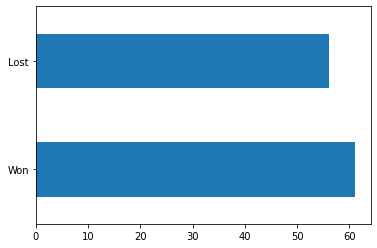

In [229]:
df[df.diff_days <= 7].stage.value_counts().plot.barh()

d:\university\isfahan uni\simester 8\data_mining\project2\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'month')]

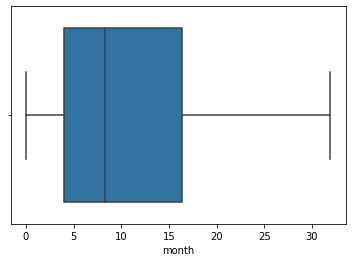

In [216]:
fig = sns.boxplot(df.diff_days/30.0)
fig.set(xlabel='month')

In [182]:
df['day_name'] = df.close_date.dt.day_name()

In [189]:
df.groupby('day_name').mean().sort_values(by='rate', ascending=False)

,close_value,rate,Lost,Won,diff_days
day_name,,,,,
Friday,1892.932576,0.063830,0.468085,0.531915,316.858156
Wednesday,1899.739671,0.056058,0.471971,0.528029,311.980108
Monday,1935.897636,0.054511,0.472744,0.527256,314.049812
Thursday,1827.925560,0.051327,0.474336,0.525664,315.801770
Saturday,1948.017254,0.035120,0.482440,0.517560,316.762477
Tuesday,1787.179556,0.005338,0.497331,0.502669,312.704626
Sunday,1826.984217,-0.027444,0.513722,0.486278,332.047170


## Let's explore in close_value
### Start from Won stages

<AxesSubplot:ylabel='Frequency'>

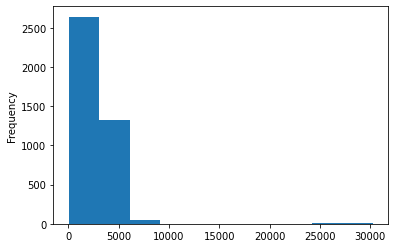

In [194]:
df[df.stage=='Won'].describe()
df[df.stage=='Won'].close_value.plot.hist()

In [209]:
df[(df.stage=='Won') & (df.close_value>10000)]['product'].value_counts()

GTK 500    14
Name: product, dtype: int64

### According to cell above, reason of low rate for GTK 500 is it's high price!
#### Absolutely there were better ways to understand this fact, but I mined in here! LOL

### How about Lost ones?

<AxesSubplot:ylabel='Frequency'>

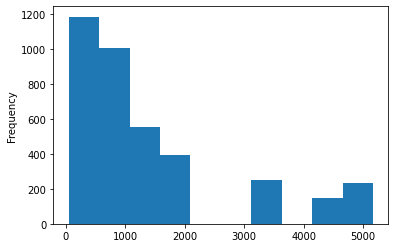

In [232]:
df[df.stage=='Lost'].describe()
df[df.stage=='Lost'].close_value.plot.hist()

In [235]:
df[(df.stage=='Lost') & (df.close_value>3000)].groupby('product').sum()

,close_value,rate,Lost,Won,diff_days
product,,,,,
GTK 500,7811.0,-2,2,0,1612
GTX Basic,623002.0,-149,149,0,50238
GTX Plus Basic,403402.0,-97,97,0,30877
GTX Plus Pro,207089.0,-53,53,0,15833
GTXPro,400509.0,-96,96,0,31589
MG Advanced,461321.0,-107,107,0,34265
MG Special,520170.0,-128,128,0,40266
